In [339]:
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import tqdm

# define the single-atom operators
sm = qt.destroy(2) # lowering operator |0><1|
sp = qt.create(2)  # raising operator |1><0|
sz = qt.sigmaz()   # Pauli Z operator |0><0| - |1><1|
n_op = sp * sm  # number operator |1><1|

# van der Waals interaction strength
C6 = 3e7 # MHz um^6

In [340]:
# lattice size
N1, N2 = 3, 3
    
# bond lengths and angles
L1, THETA1_DEG = 10.8, 180.0 # um, deg
L2, THETA2_DEG = 12.8, -70.0 # um, deg
L3, THETA3_DEG = 11.4, 60.0  # um, deg

# van der Waals interaction strength
V_r1 = C6 / L1**6  # r1, MHz
V_r2 = C6 / L2**6  # r2, MHz
V_r3 = C6 / L3**6  # r3, MHz

Omega = 2 * np.pi * 3.0 # Rabi frequency, MHz
Omega_eff = Omega / np.sqrt(2) # effective Rabi frequency
T_pulse_unit = 0.5 * (2 * np.pi) / Omega_eff 

params = {
    'Omega': Omega, # Rabi frequency, MHz
    'Omega_eff': Omega_eff, # effective Rabi frequency
    'T_pulse_unit': T_pulse_unit, 
    'mode': 'Schrodinger',    # 'Schrodinger' or 'Lindblad'
    'Gamma_decay': 0.1,
    'Gamma_dephasing': 0.05,    
    'V_map': {
        'r1': V_r1,
        'r2': V_r2,
        'r3': V_r3,
    },    
    'delta_detuning_map': {
        'r1': 0.0,
        'r2': 0.0,
        'r3': 0.0,
    }
}

In [341]:
def generate_distorted_honeycomb(N1, N2, l1, l2, l3, theta1_deg, theta2_deg, theta3_deg):
    """
    Generate the coordinates and edges of a distorted honeycomb lattice.

    Args:
    N1, N2: Lattice sizes along the two lattice vector directions
    l1, l2, l3: Lengths of the three bonds
    theta1_deg, theta2_deg, theta3_deg: Angles of the three bonds (in degrees)
    """

    # 1. Convert angles from degrees to radians
    theta1 = np.deg2rad(theta1_deg)
    theta2 = np.deg2rad(theta2_deg)
    theta3 = np.deg2rad(theta3_deg)

    # 2. Define the three basic bond vectors r1, r2, r3
    r1 = np.array([l1 * np.cos(theta1), l1 * np.sin(theta1)]) # red
    r2 = np.array([l2 * np.cos(theta2), l2 * np.sin(theta2)]) # blue
    r3 = np.array([l3 * np.cos(theta3), l3 * np.sin(theta3)]) # brown

    print("--- Vector definitions ---")
    print(f"r1: {r1} (length: {l1}, angle: {theta1_deg} deg)")
    print(f"r2: {r2} (length: {l2}, angle: {theta2_deg} deg)")
    print(f"r3: {r3} (length: {l3}, angle: {theta3_deg} deg)")

    # 3. Define lattice vectors a1, a2 for A-type nodes
    # We can obtain them by traversing the hexagon:
    # A ->(r3)-> B ->(-r2)-> A'  => a1 = r3 - r2
    # A ->(r1)-> B ->(-r2)-> A'' => a2 = r1 - r2
    a1 = r3 - r2
    a2 = r1 - r2

    # 4. Define the offset of B-type nodes relative to A-type nodes
    # We choose r3 as the base offset
    # A node position: P_A(n1, n2) = n1*a1 + n2*a2
    # B node position: P_B(n1, n2) = n1*a1 + n2*a2 + r3
    p_B_offset = r3

    node_A_pos = {} # A node coordinates dictionary { (n1,n2): [x,y] }
    node_B_pos = {} # B node coordinates dictionary { (n1,n2): [x,y] }
    node_A_id = {} # A node id dictionary { (n1,n2): i }
    node_B_id = {} # B node id dictionary { (n1,n2): i }

    coords = {}     # coordinate mapping {linear index i: [x, y]}

    # 5. Generate all node coordinates
    current_i = 0

    # A node
    for n1 in range(N1):
        for n2 in range(N2):
            pos_A = n1 * a1 + n2 * a2
            node_A_pos[(n1, n2)] = pos_A
            node_A_id[(n1, n2)] = current_i
            coords[current_i] = pos_A
            current_i += 1
            
    # B node
    for n1 in range(N1):
        for n2 in range(N2):
            pos_B = n1 * a1 + n2 * a2 + p_B_offset
            node_B_pos[(n1, n2)] = pos_B
            node_B_id[(n1, n2)] = current_i
            coords[current_i] = pos_B
            current_i += 1

    N = current_i # total number of sites

    # 6. Generate all edges (connections)
    # Each A node A(n1, n2) connects to three B nodes
    bond_list = []

    for (n1, n2), i in node_A_id.items():
        P_A = node_A_pos[(n1, n2)]
        
        # Connection 1: r3 (brown)
        # A(n1, n2) --r3--> B(n1, n2)
        idx_B = (n1, n2)
        if idx_B in node_B_pos:
            j = node_B_id[idx_B]
            P_B = node_B_pos[idx_B]
            bond_list.append((i, j, P_A, P_B, 'r3'))

        # Connection 2: r1 (red)
        # A(n1, n2) --r1--> B(n1-1, n2+1)
        idx_B = (n1 - 1, n2 + 1)
        if idx_B in node_B_pos:
            j = node_B_id[idx_B]
            P_B = node_B_pos[idx_B]
            bond_list.append((i, j, P_A, P_B, 'r1'))

        # Connection 3: r2 (blue)
        # A(n1, n2) --r2--> B(n1-1, n2)
        idx_B = (n1 - 1, n2)
        if idx_B in node_B_pos:
            j = node_B_id[idx_B]
            P_B = node_B_pos[idx_B]
            bond_list.append((i, j, P_A, P_B, 'r2'))

    return node_A_pos, node_B_pos, bond_list, node_A_id, node_B_id


In [342]:
# Generate coordinates and edges
node_A_pos, node_B_pos, bond_list, node_A_id, node_B_id = generate_distorted_honeycomb(
    N1, N2, L1, L2, L3, THETA1_DEG, THETA2_DEG, THETA3_DEG
    )

print(f"\n--- Coordinate generation completed ---")
print(f"Generated {len(node_A_pos)} A nodes in total.")
print(f"Generated {len(node_B_pos)} B nodes in total.")

--- Vector definitions ---
r1: [-1.08000000e+01  1.32261854e-15] (length: 10.8, angle: 180.0 deg)
r2: [  4.37785783 -12.02806555] (length: 12.8, angle: -70.0 deg)
r3: [5.7       9.8726896] (length: 11.4, angle: 60.0 deg)

--- Coordinate generation completed ---
Generated 9 A nodes in total.
Generated 9 B nodes in total.


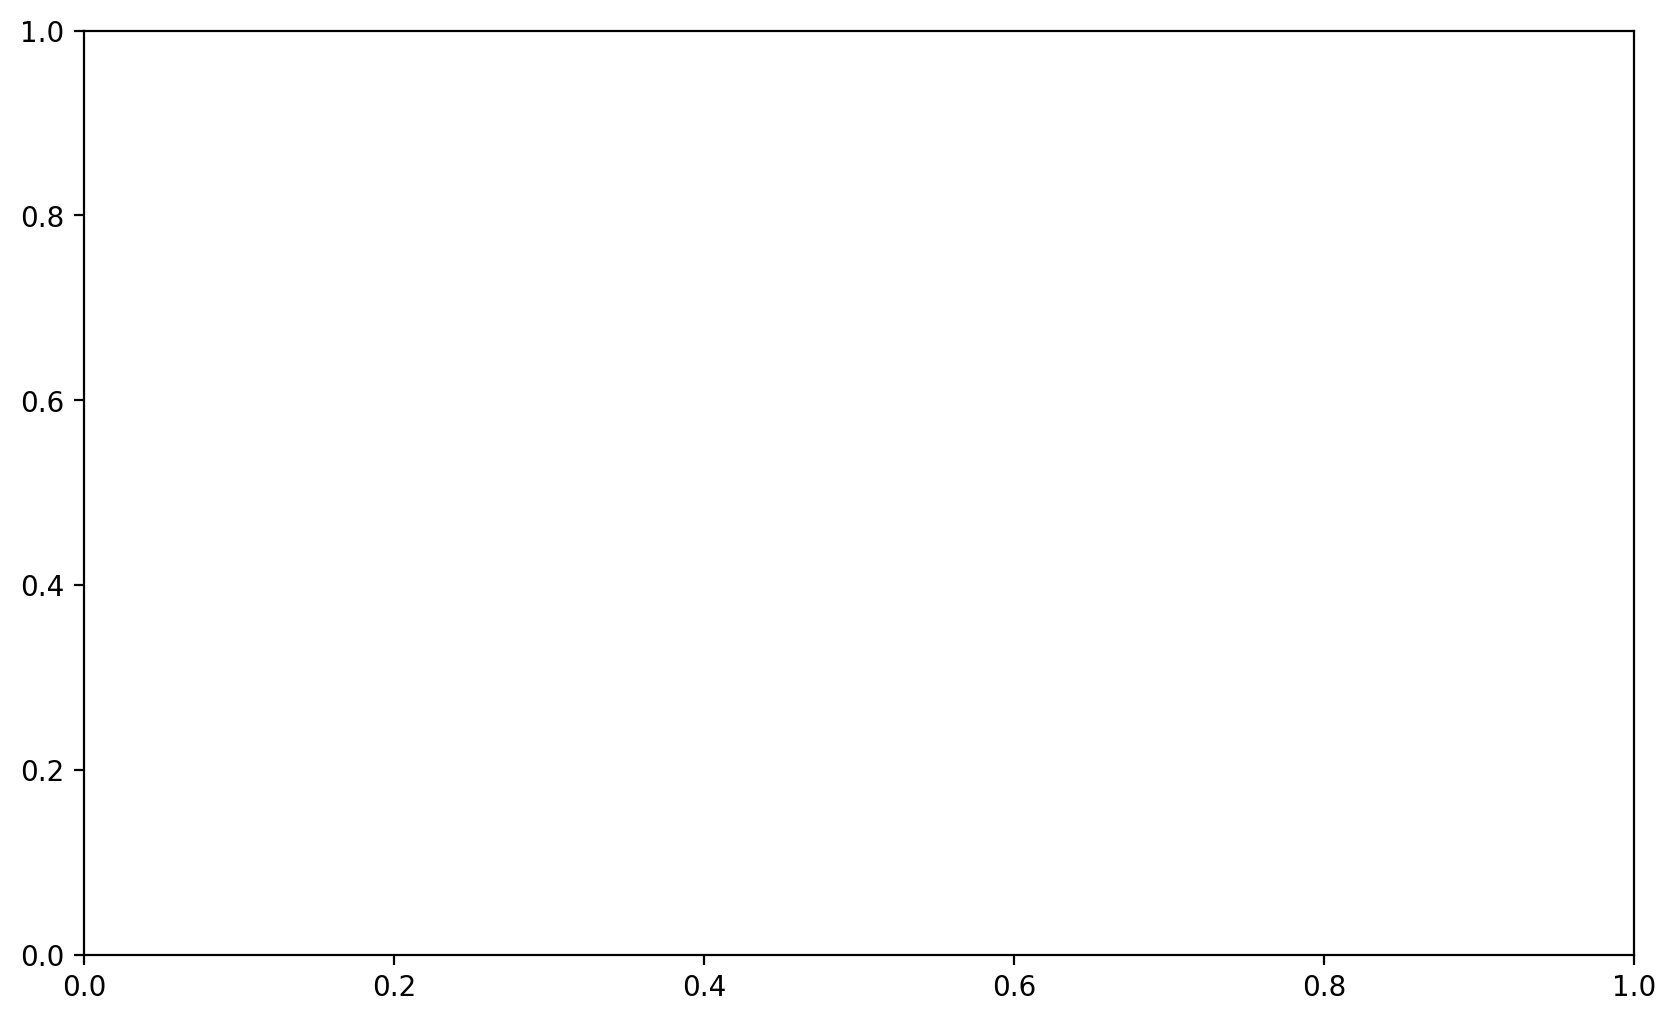

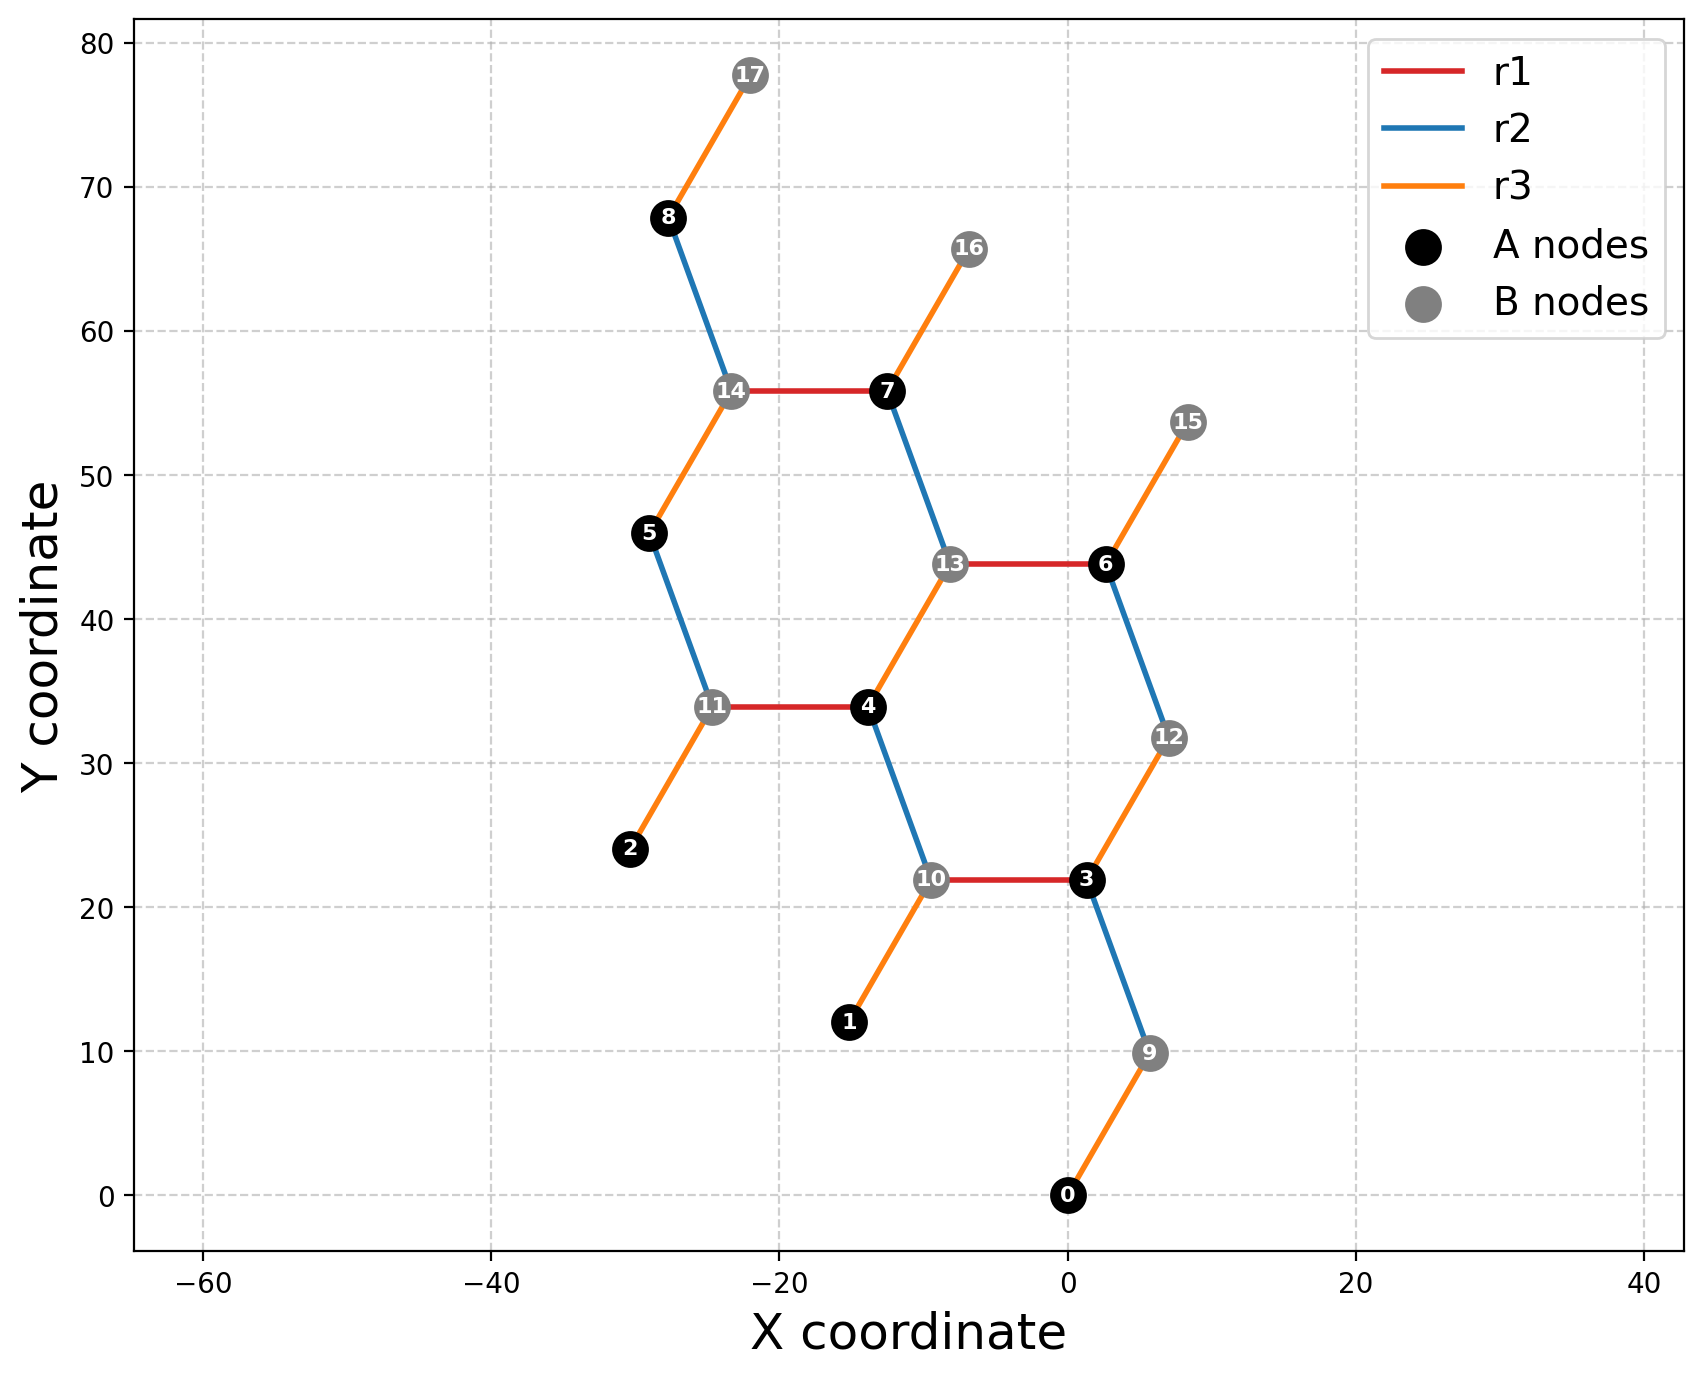

In [343]:
def plot_lattice_with_labels(node_A_pos, node_B_pos, bond_list, node_A_id=None, node_B_id=None):
    """Plot the lattice using Matplotlib with atom labels."""
    
    # Extract all A and B node coordinates for plotting
    nodes_A = np.array(list(node_A_pos.values()))
    nodes_B = np.array(list(node_B_pos.values()))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot edges
    def plot_edges(edges, color, label):
        # Add label only for the first edge to avoid legend duplication
        plotted_label = False
        for (p1, p2) in edges:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                     color=color, lw=2, 
                     label=label if not plotted_label else "")
            plotted_label = True

    edges_r1 = [bond_list[i][2:4] for i in range(len(bond_list)) if bond_list[i][4] == 'r1']
    edges_r2 = [bond_list[i][2:4] for i in range(len(bond_list)) if bond_list[i][4] == 'r2']
    edges_r3 = [bond_list[i][2:4] for i in range(len(bond_list)) if bond_list[i][4] == 'r3']

    plot_edges(edges_r1, 'tab:red', 'r1')
    plot_edges(edges_r2, 'tab:blue', 'r2')
    plot_edges(edges_r3, 'tab:orange', 'r3') 

    # Plot nodes (after edges so nodes appear on top)
    ax.scatter(nodes_A[:, 0], nodes_A[:, 1], c='black', s=150, zorder=3, label='A nodes')
    ax.scatter(nodes_B[:, 0], nodes_B[:, 1], c='gray', s=150, zorder=3, label='B nodes')

    # Add atom labels
    if node_A_id is not None:
        for (n1, n2), pos in node_A_pos.items():
            atom_id = node_A_id[(n1, n2)]
            ax.text(pos[0], pos[1], f'{atom_id}', 
                   fontsize=8, ha='center', va='center', 
                   color='white', weight='semibold', zorder=4)
    
    if node_B_id is not None:
        for (n1, n2), pos in node_B_pos.items():
            atom_id = node_B_id[(n1, n2)]
            ax.text(pos[0], pos[1], f'{atom_id}', 
                   fontsize=8, ha='center', va='center', 
                   color='white', weight='semibold', zorder=4)

    ax.set_xlabel('X coordinate', fontsize=18)
    ax.set_ylabel('Y coordinate', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axis('equal') # Ensure equal aspect ratio so angles are correct

    ax.legend(fontsize=14)
    plt.savefig('honeycomb_lattice.svg', bbox_inches='tight')
    plt.show()
    plt.close()

# Plot with labels
plot_lattice_with_labels(node_A_pos, node_B_pos, bond_list, node_A_id, node_B_id)


In [344]:

def get_operator_for_site(op, i, N):
    """
    Creates a full Hilbert space operator for a single-qubit operator 'op' acting on site 'i',
    """
    op_list = [qt.qeye(2)] * N
    op_list[i] = op
    return qt.tensor(op_list)
    

def build_hamiltonian(N, bond_list, Omega, current_delta, V_map): 
    """
    Build the system Hamiltonian.
    H = sum_j (Omega/2 * sigma_x_j - current_delta * n_j) + sum_{(i,j) in bonds} V_ij * n_i * n_j
    """
    H = 0
    
    # To improve efficiency, precompute all single-site operators
    sx_ops = [get_operator_for_site(qt.sigmax(), i, N) for i in range(N)]
    n_ops = [get_operator_for_site(n_op, i, N) for i in range(N)]
    
    # Driving term
    for i in range(N):
        H += 0.5 * Omega * sx_ops[i]
        H -= current_delta * n_ops[i]

    # Interaction terms (using precomputed bond list)
    for (i, j, _, _, bond_type) in bond_list:
        # Get V_ij from V_map, default to 0 if bond type is not defined
        V_ij = V_map.get(bond_type, 0)
        
        if V_ij > 0:
            H += V_ij * (n_ops[i] * n_ops[j])
                
    return H


def get_collapse_operators(N, Gamma_decay_val, Gamma_dephasing_val):
    """
    Build the collapse operators for the Lindblad master equation
    """
    c_ops = []
    # Decay term L_decay(rho)
    for k in range(N):
        c_ops.append(np.sqrt(Gamma_decay_val) * get_operator_for_site(sm, k, N))

    # Dephasing term L_deph(rho)
    for k in range(N):
        c_ops.append(np.sqrt(Gamma_dephasing_val) * get_operator_for_site(sz, k, N))
    return c_ops


def run_simulation(N, bond_list, params, pulse_sequence, initial_sites=[0]): 
    """
    Run time evolution using QuTiP's sesolve (Schrodinger) or mesolve (Lindblad).
    """
    
    # Initial state
    initial_state_list = [qt.basis(2, 0)] * N
    for initial_site in initial_sites:
        if initial_site < N:
            initial_state_list[initial_site] = qt.basis(2, 1)
        else:
            raise ValueError(f"Initial site index {initial_site} out of range (N={N}).")
    psi0 = qt.tensor(initial_state_list)

    # Expectation operators (tracking Rydberg population)
    e_ops = [get_operator_for_site(n_op, i, N) for i in range(N)]

    # Evolve system pulse by pulse
    history = []
    time_points = []
    t_total = 0.0
    
    print(f"Start simulation: {params['mode']} mode, N={N} sites")
    pbar = tqdm.tqdm(pulse_sequence, desc="Simulating pulses")
    for i, pulse in enumerate(pbar):
        if len(pulse) == 3:
            direction, duration, steps = pulse
            delta_override = None
        else:
            direction, duration, steps, delta_override = pulse
        pbar.set_description(f"Pulse: {direction}")

        duration = params['T_pulse_unit'] * duration
        
        if direction not in params['V_map']:
             raise ValueError(f"Warning: Pulse direction '{direction}' not defined in V_map.")
             
        if delta_override is not None:
            current_delta = params['V_map'].get(direction, 0) + delta_override
        else:
            current_delta = params['V_map'].get(direction, 0) + params['delta_detuning_map'].get(direction, 0)
        

        H_pulse = build_hamiltonian(N, bond_list, params['Omega'], current_delta, params['V_map'])
        H_func = lambda t, args: H_pulse
        
        t_pulse = np.linspace(t_total, t_total + duration, steps + 1)
        
        options = qt.Options(store_final_state=True, nsteps=5000, atol=1e-8, rtol=1e-6) 
        
        if params['mode'] == 'Schrodinger':
            result = qt.sesolve(H_func, psi0, t_pulse, e_ops=e_ops, options=options)
        elif params['mode'] == 'Lindblad':
            rho0 = psi0 * psi0.dag() if psi0.isket else psi0
            c_ops = get_collapse_operators(N, params['Gamma_decay'], params['Gamma_dephasing'])
            result = qt.mesolve(H_func, rho0, t_pulse, c_ops=c_ops, e_ops=e_ops, options=options)
        else:
            raise ValueError(f"Invalid simulation mode: {params['mode']}")
        
        if i == 0:
            time_points.extend(result.times)
            pulse_history = np.array(result.expect).T
            history.extend(pulse_history)
        else:
            time_points.extend(result.times[1:])
            pulse_history = np.array(result.expect).T
            history.extend(pulse_history[1:])

        psi0 = result.final_state
        t_total += duration

        time_period_points = time_points / (2 * params['T_pulse_unit'])

    return time_points, time_period_points, np.array(history)

Start simulation: Schrodinger mode, N=18 sites


Pulse: r3: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


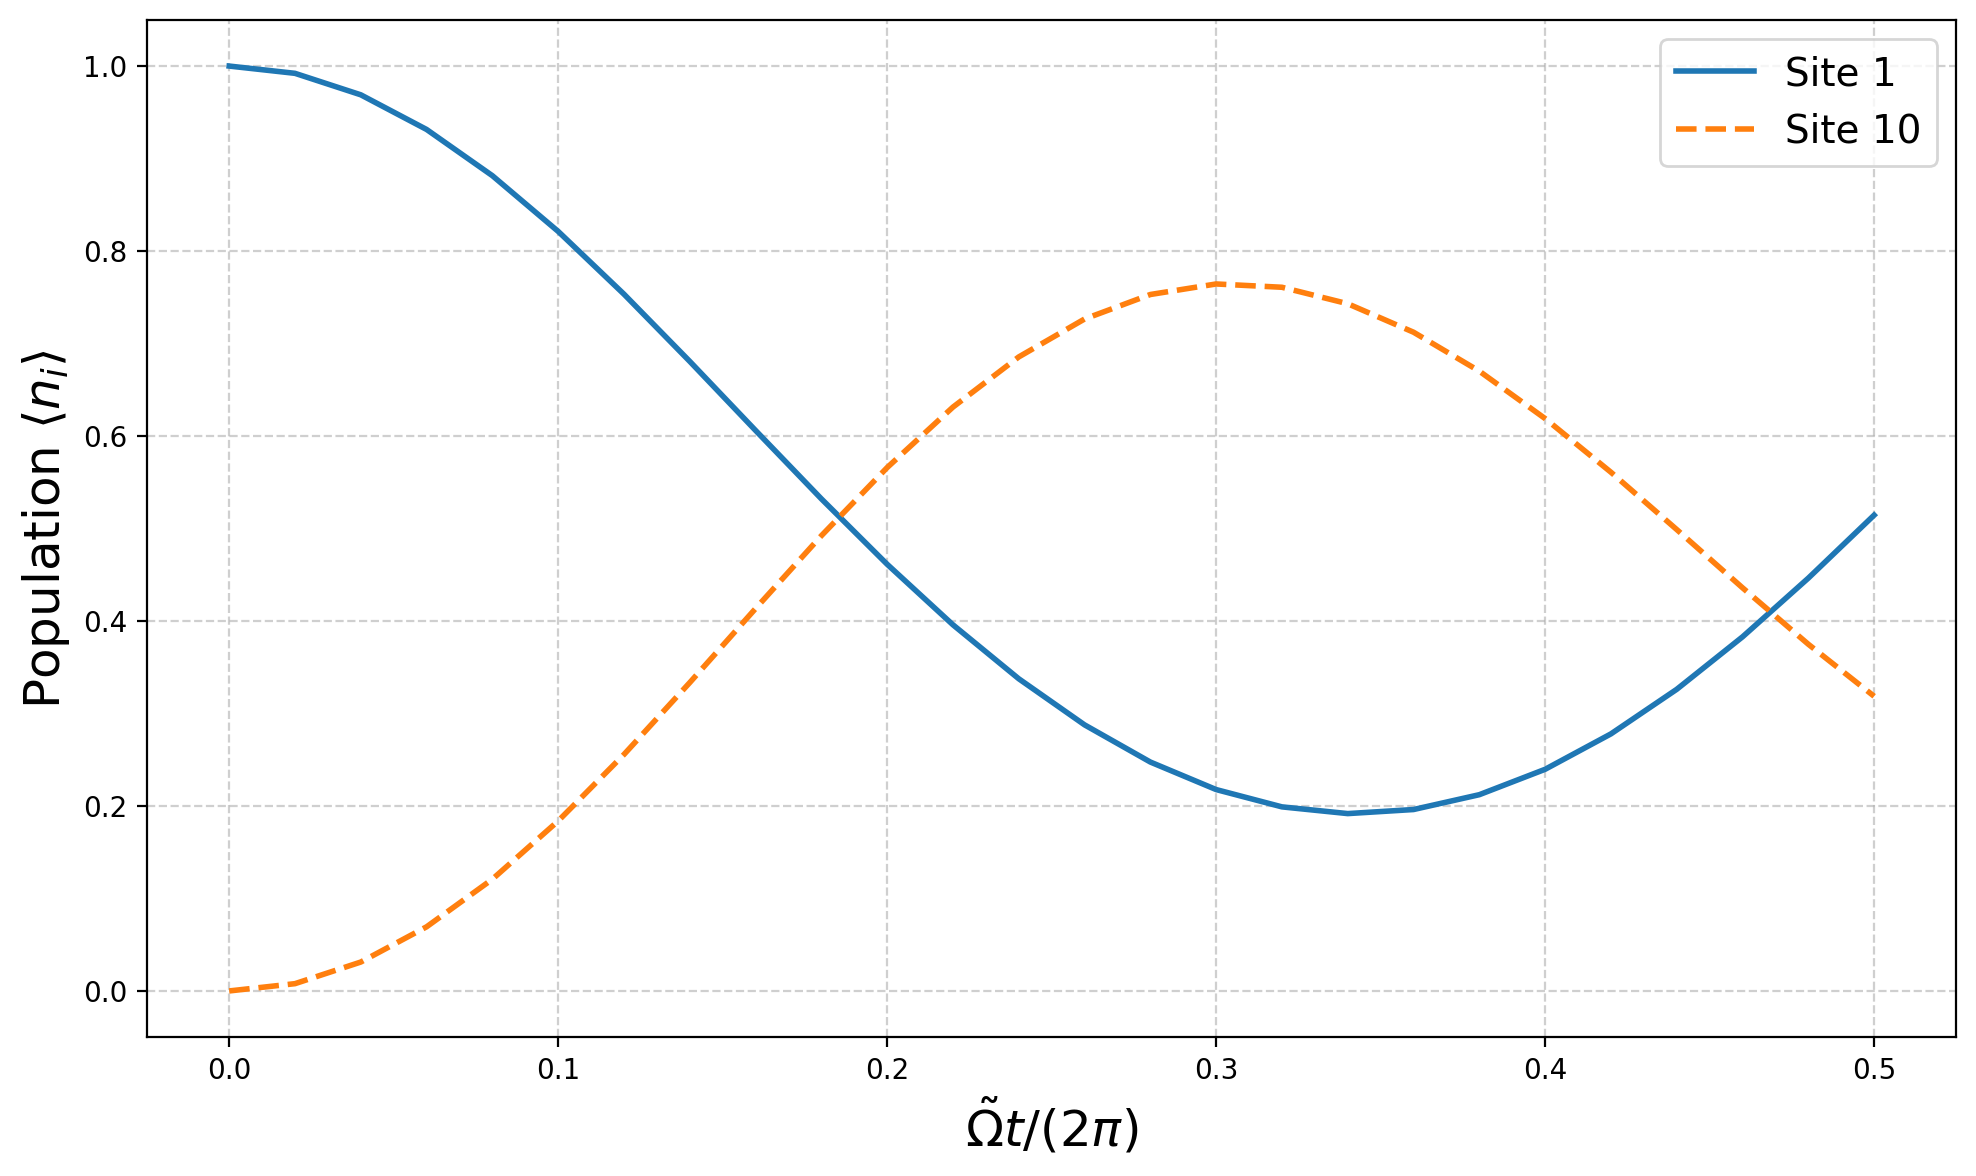

In [ ]:
initial_qubit = 1 

pulse_sequence = [
    ('r3', 1.0, 25)
]
    
times, times_period, history = run_simulation(
    N = N1 * N2 * 2,
    bond_list = bond_list,
    params = params,
    pulse_sequence = pulse_sequence,
    initial_sites = [initial_qubit] 
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(times_period, history[:, 1], label=f'Site {1}', lw=2)
ax.plot(times_period, history[:, 10], label=f'Site {10}', lw=2, ls='--')

ax.set_xlabel(r'$\tilde{\Omega}t/(2\pi)$', fontsize=18)
ax.set_ylabel(r'Population $\langle n_i\rangle$', fontsize=18)
ax.legend(loc='best', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.close()